# Exercises 6 - Proximal Gradient Method

### Why not subgradient methods?

An approximate solution can indeed be found for lasso using subgradient methods. For example, say we want to minimize the following loss function:

$$f(w;λ)=‖y−Xw‖_2^2+λ‖w‖_1$$

The gradient of the penalty term is $-\lambda$ for $w_i<0$ and $\lambda$ for $w_i>0$, but the penalty term is nondifferentiable at 0. Instead, we can use the subgradient $\lambda sgn(w)$, which is the same but has a value of 0 for $w_i=0$.

The corresponding subgradient for the loss function is:

$$g(w;λ)=−2X^T(y−Xw)+λsgn(w)$$

We can minimize the loss function using an approach (https://en.wikipedia.org/wiki/Subgradient_method) similar to gradient descent, but using the subgradient (which is equal to the gradient everywhere except 0, where the gradient is undefined). The solution can be very close to the true lasso solution, but may not contain exact zeros--where weights should have been zero, they make take extremely small values instead. This lack of true sparsity is one reason not to use subgradient methods for lasso. Dedicated solvers take advantage of the problem structure to produce truly sparse solutions in a computationally efficient way. This post says that, besides producing sparse solutions, dedicated methods (including proximal gradient methods) have faster convergence rates than subgradient methods. (https://www.quora.com/Why-doesnt-subgradient-descent-give-sparse-solutions-to-the-Lasso)

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import sparse as sp
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
from sklearn.datasets import load_diabetes
import copy
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression


from sklearn.linear_model import lasso_path
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from itertools import cycle


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

![optional caption text](figs/algorithm.png)


In [2]:
# function to load the data in diabetes progression in 442 adults
def load_data():
    ## Read in the CSV data
    feature_matrix = np.loadtxt("../../data/diabetesX.csv",skiprows=1,delimiter=",")
    response = np.loadtxt("../../data/diabetesY.csv")
    
    # set mean of the response variable to zero
    response = response - response.mean(axis = 0)
    
    return feature_matrix, response


def load_data_sklearn():
    (feature_matrix, response) = load_diabetes(return_X_y=True)
    
    return feature_matrix, response

def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis = 0)
    normalized_features = feature_matrix/norms
    return (normalized_features, norms)

In [3]:
X, y = load_data()
X, norm = normalize_features(X)
y = y.reshape(y.shape[0],1)

N = y.shape[0]
dim = X.shape[1]

# lamda = 1/np.sqrt(N);
lamda = 0.0
print(lamda)
L = (np.linalg.svd(X)[1][0])**2
print(L)
max_iter = 5000
np.random.seed(50)
w = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim))).T
w = np.zeros((dim, 1))

0.0
10.7743049768


# Calculate loss using sklearn

In [4]:
X, Y = load_data()
X, norms = normalize_features(X) 

testLambdas = []
testLambdas.append(lamda*N)
print(testLambdas)

mse = []

for lambd in testLambdas:
    lassofit = Lasso(alpha = lambd);
    lassofit.fit(X,Y);
    predicted = lassofit.predict(X)
    diff = predicted - Y
    thismse = np.linalg.norm(diff)**2 / np.size(diff)
    mse.append(thismse)

print(mse[0]/2)
opt = mse[0]/2
# plt.plot(testLambdas, mse, linewidth=4.0)
# plt.xlabel("Lambda")
# plt.ylabel("Mean Squared Error")
# plt.title("In-Sample Mean Squared prediction error (in-sample MSE)")


[0.0]
1214.89942306


/Users/anvaribs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if sys.path[0] == '':
/Users/anvaribs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/anvaribs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Utility functions

In [5]:
## Define the objective, subgradient oracle, proximal operator, and gradient for smoothed function (Huber)  
def obj(w):
    r = X*w-y;
    return np.sum(np.multiply(r,r))/(2) +  lamda * np.sum(np.abs(w))

def subgrad(w):
    return  X.T*(X*w-y) + lamda*np.sign(w) 

def f_grad(w):
    return (X.T*(X*w-y))

def soft_threshod(w,mu):
    return np.multiply(np.sign(w), np.maximum(np.abs(w)- mu,0))  

def smooth_grad(w, mu):
    temp = np.multiply((np.abs(w)<=mu),w/mu) + np.multiply((np.abs(w)>mu),np.sign(w)) 
    return X.T*(X*w-y) + lamda * temp

## Proximal Gradient

In [6]:
## Proximal Gadient 
w = np.matrix([0.0]*dim).T
obj_PG = []
gamma = 1/L

for t in range(0, max_iter):
    obj_val = obj(w)
    w = w - gamma* f_grad(w)
    w= soft_threshod(w,lamda* gamma)
    
    obj_PG.append(obj_val.item()/N)
    if (t%5==0):
        print('iter= {},\tobjective= {:3f}'.format(t, obj_val.item()/N))


iter= 0,	objective= 2964.942448
iter= 5,	objective= 1532.289723
iter= 10,	objective= 1400.618496
iter= 15,	objective= 1345.389210
iter= 20,	objective= 1315.685568
iter= 25,	objective= 1297.846066
iter= 30,	objective= 1286.337005
iter= 35,	objective= 1278.502274
iter= 40,	objective= 1272.928907
iter= 45,	objective= 1268.809554
iter= 50,	objective= 1265.657800
iter= 55,	objective= 1263.168458
iter= 60,	objective= 1261.143865
iter= 65,	objective= 1259.452681
iter= 70,	objective= 1258.005758
iter= 75,	objective= 1256.741479
iter= 80,	objective= 1255.616555
iter= 85,	objective= 1254.600121
iter= 90,	objective= 1253.669856
iter= 95,	objective= 1252.809401
iter= 100,	objective= 1252.006594
iter= 105,	objective= 1251.252275
iter= 110,	objective= 1250.539446
iter= 115,	objective= 1249.862681
iter= 120,	objective= 1249.217714
iter= 125,	objective= 1248.601137
iter= 130,	objective= 1248.010189
iter= 135,	objective= 1247.442598
iter= 140,	objective= 1246.896468
iter= 145,	objective= 1246.370191
it

iter= 1265,	objective= 1221.245283
iter= 1270,	objective= 1221.220385
iter= 1275,	objective= 1221.195670
iter= 1280,	objective= 1221.171137
iter= 1285,	objective= 1221.146783
iter= 1290,	objective= 1221.122607
iter= 1295,	objective= 1221.098608
iter= 1300,	objective= 1221.074782
iter= 1305,	objective= 1221.051129
iter= 1310,	objective= 1221.027647
iter= 1315,	objective= 1221.004333
iter= 1320,	objective= 1220.981188
iter= 1325,	objective= 1220.958208
iter= 1330,	objective= 1220.935392
iter= 1335,	objective= 1220.912738
iter= 1340,	objective= 1220.890246
iter= 1345,	objective= 1220.867913
iter= 1350,	objective= 1220.845737
iter= 1355,	objective= 1220.823718
iter= 1360,	objective= 1220.801854
iter= 1365,	objective= 1220.780143
iter= 1370,	objective= 1220.758584
iter= 1375,	objective= 1220.737175
iter= 1380,	objective= 1220.715915
iter= 1385,	objective= 1220.694802
iter= 1390,	objective= 1220.673835
iter= 1395,	objective= 1220.653013
iter= 1400,	objective= 1220.632334
iter= 1405,	objectiv

iter= 2440,	objective= 1218.169846
iter= 2445,	objective= 1218.163158
iter= 2450,	objective= 1218.156499
iter= 2455,	objective= 1218.149867
iter= 2460,	objective= 1218.143264
iter= 2465,	objective= 1218.136688
iter= 2470,	objective= 1218.130140
iter= 2475,	objective= 1218.123620
iter= 2480,	objective= 1218.117127
iter= 2485,	objective= 1218.110660
iter= 2490,	objective= 1218.104221
iter= 2495,	objective= 1218.097809
iter= 2500,	objective= 1218.091423
iter= 2505,	objective= 1218.085064
iter= 2510,	objective= 1218.078731
iter= 2515,	objective= 1218.072424
iter= 2520,	objective= 1218.066143
iter= 2525,	objective= 1218.059888
iter= 2530,	objective= 1218.053659
iter= 2535,	objective= 1218.047455
iter= 2540,	objective= 1218.041277
iter= 2545,	objective= 1218.035124
iter= 2550,	objective= 1218.028995
iter= 2555,	objective= 1218.022892
iter= 2560,	objective= 1218.016814
iter= 2565,	objective= 1218.010760
iter= 2570,	objective= 1218.004731
iter= 2575,	objective= 1217.998726
iter= 2580,	objectiv

iter= 3880,	objective= 1216.977891
iter= 3885,	objective= 1216.975355
iter= 3890,	objective= 1216.972825
iter= 3895,	objective= 1216.970302
iter= 3900,	objective= 1216.967786
iter= 3905,	objective= 1216.965276
iter= 3910,	objective= 1216.962774
iter= 3915,	objective= 1216.960278
iter= 3920,	objective= 1216.957789
iter= 3925,	objective= 1216.955307
iter= 3930,	objective= 1216.952831
iter= 3935,	objective= 1216.950362
iter= 3940,	objective= 1216.947899
iter= 3945,	objective= 1216.945444
iter= 3950,	objective= 1216.942994
iter= 3955,	objective= 1216.940552
iter= 3960,	objective= 1216.938115
iter= 3965,	objective= 1216.935686
iter= 3970,	objective= 1216.933262
iter= 3975,	objective= 1216.930845
iter= 3980,	objective= 1216.928435
iter= 3985,	objective= 1216.926031
iter= 3990,	objective= 1216.923633
iter= 3995,	objective= 1216.921242
iter= 4000,	objective= 1216.918857
iter= 4005,	objective= 1216.916478
iter= 4010,	objective= 1216.914106
iter= 4015,	objective= 1216.911740
iter= 4020,	objectiv

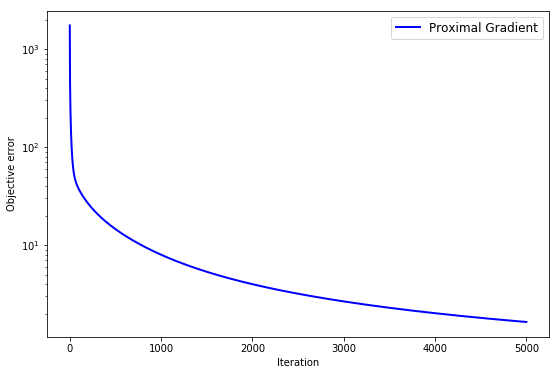

In [7]:
## Plot objective error vs. iteration (log scale)
t = np.arange(0, max_iter)
fig, ax = plt.subplots(figsize = (9, 6))
plt.semilogy(t, np.array(obj_PG)-opt, 'b', linewidth = 2, label = 'Proximal Gradient')
plt.legend(prop={'size':12})
plt.xlabel('Iteration')
plt.ylabel('Objective error')

## Proximal Gradient with Backtracking Line-Search

In [8]:
## Proximal Gadient with Line Search
w = np.matrix([0.0]*dim).T
obj_PG_LS = []
LL=1
gamma = 1/LL
beta = 1.2
for t in range(0, max_iter):
    obj_val = obj(w)
    w_prev = w
    delta = 1
    while (delta>1e-3):
        gamma = 1/LL
        w = w_prev - gamma * f_grad(w_prev)    
        w = soft_threshod(w,lamda * gamma)
        delta = obj(w) - obj_val - f_grad(w_prev).T*(w-w_prev)- (LL/2) * np.linalg.norm(w-w_prev)**2
        LL = LL*beta
    LL = LL/beta   
    
    obj_PG_LS.append(obj_val.item()/N)

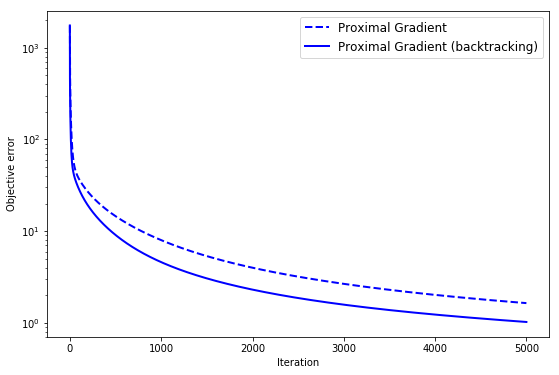

In [9]:
## Plot objective error vs. iteration (log scale)
t = np.arange(0, max_iter)
fig, ax = plt.subplots(figsize = (9, 6))
plt.semilogy(t, np.array(obj_PG)-opt, 'b--', linewidth = 2, label = 'Proximal Gradient')
plt.semilogy(t, np.array(obj_PG_LS)-opt, 'b', linewidth = 2, label = 'Proximal Gradient (backtracking)')
plt.legend(prop={'size':12})
plt.xlabel('Iteration')
plt.ylabel('Objective error')

## Accelerated Proximal Gradient

In [10]:
## Nesterovs' Accelerated Proximal Gradient
w = np.matrix([0.0]*dim).T
v = w
obj_APG = []
gamma = 1/L
for t in range(0, max_iter):
    obj_val = obj(w)
    w_prev = w
    w = v - gamma * f_grad(v)
    w = soft_threshod(w,lamda * gamma)
    v = w + t/(t+3) * (w - w_prev)

    obj_APG.append(obj_val.item()/N)
    if (t%5==0):
        print('iter= {},\tobjective= {:3f}'.format(t, obj_val.item()/N))

iter= 0,	objective= 2964.942448
iter= 5,	objective= 1469.070061
iter= 10,	objective= 1311.900045
iter= 15,	objective= 1270.299982
iter= 20,	objective= 1258.582531
iter= 25,	objective= 1252.726884
iter= 30,	objective= 1247.382853
iter= 35,	objective= 1242.591159
iter= 40,	objective= 1238.657677
iter= 45,	objective= 1235.434109
iter= 50,	objective= 1232.760858
iter= 55,	objective= 1230.517996
iter= 60,	objective= 1228.603319
iter= 65,	objective= 1226.961121
iter= 70,	objective= 1225.538588
iter= 75,	objective= 1224.296479
iter= 80,	objective= 1223.214605
iter= 85,	objective= 1222.273634
iter= 90,	objective= 1221.457848
iter= 95,	objective= 1220.759518
iter= 100,	objective= 1220.170037
iter= 105,	objective= 1219.676750
iter= 110,	objective= 1219.266424
iter= 115,	objective= 1218.924237
iter= 120,	objective= 1218.633330
iter= 125,	objective= 1218.379126
iter= 130,	objective= 1218.152006
iter= 135,	objective= 1217.946148
iter= 140,	objective= 1217.758040
iter= 145,	objective= 1217.585639
it

iter= 1780,	objective= 1208.803396
iter= 1785,	objective= 1208.793925
iter= 1790,	objective= 1208.784586
iter= 1795,	objective= 1208.775378
iter= 1800,	objective= 1208.766301
iter= 1805,	objective= 1208.757353
iter= 1810,	objective= 1208.748533
iter= 1815,	objective= 1208.739842
iter= 1820,	objective= 1208.731279
iter= 1825,	objective= 1208.722844
iter= 1830,	objective= 1208.714536
iter= 1835,	objective= 1208.706355
iter= 1840,	objective= 1208.698301
iter= 1845,	objective= 1208.690374
iter= 1850,	objective= 1208.682575
iter= 1855,	objective= 1208.674902
iter= 1860,	objective= 1208.667357
iter= 1865,	objective= 1208.659939
iter= 1870,	objective= 1208.652648
iter= 1875,	objective= 1208.645484
iter= 1880,	objective= 1208.638445
iter= 1885,	objective= 1208.631533
iter= 1890,	objective= 1208.624745
iter= 1895,	objective= 1208.618081
iter= 1900,	objective= 1208.611539
iter= 1905,	objective= 1208.605119
iter= 1910,	objective= 1208.598819
iter= 1915,	objective= 1208.592637
iter= 1920,	objectiv

iter= 3265,	objective= 1208.513771
iter= 3270,	objective= 1208.513141
iter= 3275,	objective= 1208.512500
iter= 3280,	objective= 1208.511847
iter= 3285,	objective= 1208.511183
iter= 3290,	objective= 1208.510509
iter= 3295,	objective= 1208.509824
iter= 3300,	objective= 1208.509128
iter= 3305,	objective= 1208.508423
iter= 3310,	objective= 1208.507708
iter= 3315,	objective= 1208.506983
iter= 3320,	objective= 1208.506248
iter= 3325,	objective= 1208.505505
iter= 3330,	objective= 1208.504752
iter= 3335,	objective= 1208.503991
iter= 3340,	objective= 1208.503221
iter= 3345,	objective= 1208.502442
iter= 3350,	objective= 1208.501656
iter= 3355,	objective= 1208.500861
iter= 3360,	objective= 1208.500058
iter= 3365,	objective= 1208.499248
iter= 3370,	objective= 1208.498429
iter= 3375,	objective= 1208.497604
iter= 3380,	objective= 1208.496771
iter= 3385,	objective= 1208.495931
iter= 3390,	objective= 1208.495084
iter= 3395,	objective= 1208.494231
iter= 3400,	objective= 1208.493371
iter= 3405,	objectiv

iter= 4725,	objective= 1208.418570
iter= 4730,	objective= 1208.418807
iter= 4735,	objective= 1208.419042
iter= 4740,	objective= 1208.419274
iter= 4745,	objective= 1208.419503
iter= 4750,	objective= 1208.419729
iter= 4755,	objective= 1208.419951
iter= 4760,	objective= 1208.420171
iter= 4765,	objective= 1208.420387
iter= 4770,	objective= 1208.420599
iter= 4775,	objective= 1208.420809
iter= 4780,	objective= 1208.421015
iter= 4785,	objective= 1208.421217
iter= 4790,	objective= 1208.421417
iter= 4795,	objective= 1208.421612
iter= 4800,	objective= 1208.421804
iter= 4805,	objective= 1208.421992
iter= 4810,	objective= 1208.422177
iter= 4815,	objective= 1208.422358
iter= 4820,	objective= 1208.422535
iter= 4825,	objective= 1208.422708
iter= 4830,	objective= 1208.422878
iter= 4835,	objective= 1208.423044
iter= 4840,	objective= 1208.423206
iter= 4845,	objective= 1208.423364
iter= 4850,	objective= 1208.423518
iter= 4855,	objective= 1208.423669
iter= 4860,	objective= 1208.423815
iter= 4865,	objectiv

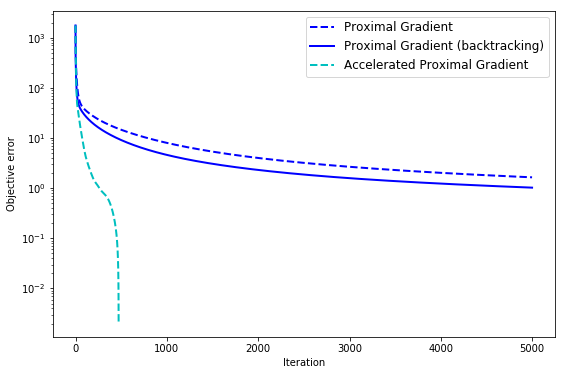

In [11]:
## Plot objective vs. iteration
t = np.arange(0, max_iter)
fig, ax = plt.subplots(figsize = (9, 6))
ax.semilogy(t, np.array(obj_PG)-opt, 'b--', linewidth = 2, label = 'Proximal Gradient')
ax.semilogy(t, np.array(obj_PG_LS)-opt, 'b', linewidth = 2, label = 'Proximal Gradient (backtracking)')
ax.semilogy(t, np.array(obj_APG)-opt, 'c--', linewidth = 2, label = 'Accelerated Proximal Gradient')
ax.legend(prop={'size':12})
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective error')